In [98]:
import numpy as np
import pandas as pd
import xgboost as xgb
%matplotlib inline

In [6]:
path = '/home/gleb/TradingDataSets/BSC/data/m1/USD000UTSTOM/'

In [8]:
np.load(path + 'time.npy')

array([datetime.datetime(2015, 1, 5, 10, 0),
       datetime.datetime(2015, 1, 5, 10, 1),
       datetime.datetime(2015, 1, 5, 10, 2), ...,
       datetime.datetime(2016, 8, 31, 18, 33),
       datetime.datetime(2016, 8, 31, 18, 34),
       datetime.datetime(2016, 8, 31, 18, 35)], dtype=object)

In [79]:
def get_pd_full_ticker_data(ticker, freq, lags=1, y_forward_shift = 0):
    path = '/home/gleb/TradingDataSets/BSC/data/'
    path += freq +'/'
    path += ticker +'/'
    
    final = pd.DataFrame()
    final['close'] = np.load(path + 'close.npy')
    final['open'] = np.load(path + 'open.npy')
    final['open'] = (final['close'] - final['open'])/final['close']
    final['high'] = np.load(path + 'high.npy')
    final['high'] = (final['close'] - final['high'])/final['close']
    final['low'] = np.load(path + 'low.npy')
    final['low'] = (final['close'] - final['low'])/final['close']
    final['time'] = np.load(path + 'time.npy')
    final['count'] = np.load(path + 'count.npy')
    final['volume'] = np.load(path + 'volume.npy')
    final['close'] = final.close.pct_change()
    final = final.set_index('time')
    for i in range(1, lags+1):
        for column in ['open', 'high', 'low', 'count', 'volume', 'close']:
            final[column + '_lag' + str(i)] = final[column].shift(i)
    del final['open']
    del final['high']
    del final['low']
    del final['count']
    del final['volume']
    final['close'] = final['close'].shift(-y_forward_shift)
    final = final.dropna(axis=0)
    y = final['close']
    del final['close']
    return y, final.dropna(axis=0)

In [80]:
y, X = get_pd_full_ticker_data('USD000UTSTOM', 'm1')

In [145]:
X.head()

,open_lag1,high_lag1,low_lag1,count_lag1,volume_lag1,close_lag1,open_lag2,high_lag2,low_lag2,count_lag2,...,low_lag9,count_lag9,volume_lag9,close_lag9,open_lag10,high_lag10,low_lag10,count_lag10,volume_lag10,close_lag10
time,,,,,,,,,,,,,,,,,,,,,
2015-01-05 10:11:00,0.001394,-0.001256,0.005557,65.0,1356000.0,0.000516,-0.006696,-0.006963,0.000878,61.0,...,0.004971,117.0,7626000.0,0.004220,0.002432,-0.000729,0.003280,97.0,11446000.0,0.005111
2015-01-05 10:12:00,0.001254,-0.001392,0.002363,28.0,364000.0,0.001256,0.001394,-0.001256,0.005557,65.0,...,0.000861,81.0,4369000.0,0.000034,0.004211,-0.000608,0.004971,117.0,7626000.0,0.004220
2015-01-05 10:13:00,-0.001272,-0.001968,0.000679,30.0,1358000.0,-0.000387,0.001254,-0.001392,0.002363,28.0,...,0.000034,93.0,5371000.0,-0.006371,-0.000270,-0.001662,0.000861,81.0,4369000.0,0.000034
2015-01-05 10:14:00,0.000172,-0.000722,0.000989,15.0,774000.0,-0.000309,-0.001272,-0.001968,0.000679,30.0,...,0.009310,168.0,7377000.0,-0.013877,-0.006896,-0.006905,0.000034,93.0,5371000.0,-0.006371
2015-01-05 10:15:00,0.002796,0.000000,0.003431,37.0,1257000.0,0.002450,0.000172,-0.000722,0.000989,15.0,...,0.004330,78.0,4644000.0,0.004341,-0.014150,-0.014150,0.009310,168.0,7377000.0,-0.013877


In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

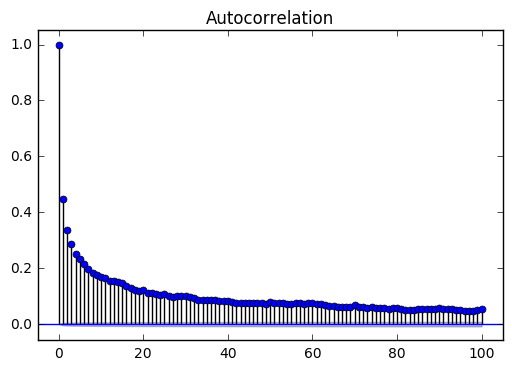

In [86]:
plot_acf(X.volume_lag1, lags=100)

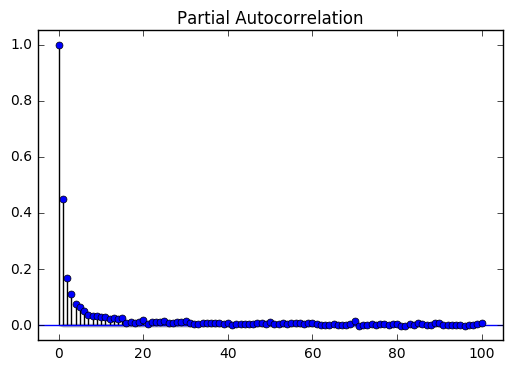

In [87]:
plot_pacf(X.volume_lag1, lags=100)

In [88]:
import xgboost as xgb

In [106]:
param = {'max_depth': 5, 'min_child_weight': 6, 'eta': 0.05, 'silent': 1, 'objective': 'reg:linear',
         'subsample': 0.5, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0}

In [178]:
y, X = get_pd_full_ticker_data('USD000UTSTOM', 'm1', lags=10, y_forward_shift=5)
dmatrix = xgb.DMatrix(X, y)

In [179]:
X.shape

(216300, 60)

In [180]:
cv = xgb.cv(param, dmatrix, num_boost_round=300, nfold=5, metrics={'rmse'})

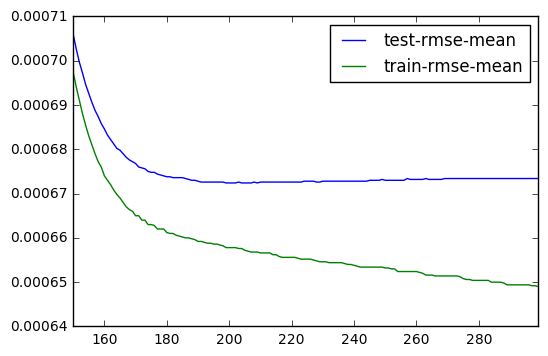

In [181]:
cv.loc[150:, ['test-rmse-mean', 'train-rmse-mean']].plot()

In [182]:
print(cv.loc[199, 'test-rmse-mean'])

0.0006724


In [127]:
print(cv.loc[199, 'test-rmse-mean'])

0.0006736


In [132]:
print(cv.loc[199, 'test-rmse-mean'])

0.000673


In [184]:
model = xgb.train(param, dmatrix, num_boost_round=200)

In [185]:
pd.Series(model.get_fscore()).sort_values(ascending=False)

count_lag5      137
open_lag5        82
open_lag9        42
low_lag5         40
open_lag1        38
high_lag1        36
open_lag3        35
low_lag8         34
open_lag7        30
open_lag4        30
low_lag1         29
close_lag10      28
open_lag10       27
high_lag2        26
open_lag6        25
open_lag8        25
low_lag2         24
close_lag5       24
volume_lag3      24
close_lag4       24
volume_lag5      24
low_lag6         24
high_lag4        24
open_lag2        23
low_lag4         23
high_lag8        22
high_lag3        22
low_lag9         21
high_lag6        20
close_lag3       20
count_lag8       19
close_lag1       19
close_lag9       17
close_lag6       17
high_lag5        17
high_lag7        16
count_lag6       15
high_lag9        15
count_lag2       14
count_lag1       13
low_lag10        13
count_lag3       13
volume_lag4      12
low_lag7         12
volume_lag2      12
volume_lag8      12
count_lag7       11
count_lag4       11
volume_lag10     11
close_lag8       11


In [186]:
predicted = model.predict(dmatrix)
X['predicted'] = predicted + 0.00000001
X['error'] = y - X['predicted']
X['actual'] = y + 0.00000001
# X.plot(kind='scatter', x='predicted', y='error', figsize=(12,12), xlim=[-0.03, 0.03], ylim=[-0.03, 0.03])

In [187]:
X['right'] = np.sign(X['actual']) * np.sign(X['predicted'])

In [188]:
X['pnl'] = np.abs(X['actual'])*X['right']

In [189]:
X['pnl']

time
2015-01-05 10:11:00    1.025651e-03
2015-01-05 10:12:00    6.907435e-03
2015-01-05 10:13:00    3.396077e-03
2015-01-05 10:14:00   -8.996867e-04
2015-01-05 10:15:00    1.595174e-03
2015-01-05 10:16:00    1.159654e-03
2015-01-05 10:17:00    1.312731e-03
2015-01-05 10:18:00    1.692473e-03
2015-01-05 10:19:00    2.831335e-03
2015-01-05 10:20:00    3.346816e-03
2015-01-05 10:21:00    1.496773e-03
2015-01-05 10:22:00    4.116341e-03
2015-01-05 10:23:00    3.310132e-03
2015-01-05 10:24:00    1.752177e-03
2015-01-05 10:25:00   -1.382227e-03
2015-01-05 10:26:00   -1.141747e-03
2015-01-05 10:27:00    2.527671e-03
2015-01-05 10:28:00    7.680050e-05
2015-01-05 10:29:00    7.081147e-04
2015-01-05 10:30:00    8.623145e-04
2015-01-05 10:31:00   -1.100400e-03
2015-01-05 10:32:00    8.710604e-04
2015-01-05 10:33:00   -4.777975e-04
2015-01-05 10:34:00   -1.000000e-08
2015-01-05 10:35:00    4.609732e-04
2015-01-05 10:36:00    1.919785e-03
2015-01-05 10:37:00    5.385666e-04
2015-01-05 10:38:00   -

In [194]:
np.abs(X['predicted']).describe()

count    2.163000e+05
mean     2.184312e-05
std      5.635507e-05
min      1.000000e-08
25%      1.792120e-05
50%      1.792120e-05
75%      1.792120e-05
max      1.382111e-02
Name: predicted, dtype: float64

In [195]:
np.abs(X['predicted']).quantile(0.25)

1.7921196558745578e-05

In [190]:
start = 1
for return_value in X['pnl'].values:
    start = start*(1+return_value)
print(start)

25.9544832429


In [191]:
X['pnl'].sum()

3.304967242961073

In [197]:
X.loc[np.abs(X.predicted)>np.abs(X['predicted']).quantile(0.25),'pnl'].sum()

3.442141846748123